# CNN을 활용한 유사도 분석
- CNN을 활용하면 순서정보는 적어지지만, n-gram정보를 얻을 수 있다.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
DATA_IN_PATH = '/content/drive/MyDrive/2021-1/AI데이터활용교재개발/자연어처리(텐서플로,머신러닝)/code/data/quora-question-pairs/'
DATA_OUT_PATH =  '/content/drive/MyDrive/2021-1/AI데이터활용교재개발/자연어처리(텐서플로,머신러닝)/code/data/quora-question-pairs/out/'

TRAIN_Q1_DATA_FILE = 'train_q1.npy'
TRAIN_Q2_DATA_FILE = 'train_q2.npy'
TRAIN_LABEL_DATA_FILE = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [6]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [4]:

q1_data = np.load(open(DATA_IN_PATH + TRAIN_Q1_DATA_FILE, 'rb'))
q2_data = np.load(open(DATA_IN_PATH + TRAIN_Q2_DATA_FILE, 'rb'))
labels = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA_FILE, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [7]:
model_name = 'cnn_similarity'
BATCH_SIZE = 1024
NUM_EPOCHS = 100
VALID_SPLIT = 0.1
MAX_LEN = 31

kargs = {'model_name': model_name,
         'vocab_size': prepro_configs['vocab_size'], # 단어의 수
         'word_embedding_dimension': 100, # 단어 임베딩을 위한 차원 값(단어의 차원 수)
         'conv_num_filters': 300, # 합성곱 레이어를 위한 차원값 
         'conv_window_size': 3, # 합성곱 레이어를 위한 윈도우 값 
         'max_pool_seq_len': MAX_LEN, # max pooling을 위한 고정 값
         'sent_embedding_dimension': 128, # 문장 임베딩을 위한 차원 값
         'dropout_rate': 0.2,
         'hidden_dimension': 200, # 마지막 dense 레이어에 대한 차원 값
         'output_dimension':1}

In [8]:

class SentenceEmbedding(layers.Layer):
    def __init__(self, **kargs):
        super(SentenceEmbedding, self).__init__()

        self.conv = layers.Conv1D(kargs['conv_num_filters'], kargs['conv_window_size'], 
                                activation=tf.keras.activations.relu, 
                                padding='same')
        self.max_pool = layers.MaxPool1D(kargs['max_pool_seq_len'], 1)
        self.dense = layers.Dense(kargs['sent_embedding_dimension'], 
                              activation=tf.keras.activations.relu)

    def call(self, x):
        x = self.conv(x)
        x = self.max_pool(x)
        x = self.dense(x)
        
        return tf.squeeze(x, 1)

In [13]:
import pdb

class SentenceSimilarityModel(tf.keras.Model):
    def __init__(self, **kargs):
        super(SentenceSimilarityModel, self).__init__(name=kargs['model_name'])
        
        self.word_embedding = layers.Embedding(kargs['vocab_size'], kargs['word_embedding_dimension'])
        self.base_encoder = SentenceEmbedding(**kargs)
        self.hypo_encoder = SentenceEmbedding(**kargs)
        self.dense = layers.Dense(kargs['hidden_dimension'], 
                                           activation=tf.keras.activations.relu)
        self.logit = layers.Dense(1, activation=tf.keras.activations.sigmoid)
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        
    def call(self, x):
        pdb.set_trace()
        x1, x2 = x# x1 (none,31), x2 (none,31)
        b_x = self.word_embedding(x1) # b_x : (none, 31,100)
        h_x = self.word_embedding(x2)
        b_x = self.dropout(b_x)
        h_x = self.dropout(h_x)
        
        b_x = self.base_encoder(b_x) # (none, 128)
        h_x = self.hypo_encoder(h_x)
        
        e_x = tf.concat([b_x, h_x], -1) #(none, 256)
        e_x = self.dense(e_x)#(none, 200)
        e_x = self.dropout(e_x)#(none, 200)
        
        return self.logit(e_x)


In [14]:
model = SentenceSimilarityModel(**kargs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [15]:
# overfitting을 막기 위한 ealrystop 추가j
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

/content/drive/MyDrive/2021-1/AI데이터활용교재개발/자연어처리(텐서플로,머신러닝)/code/data/quora-question-pairs/out/cnn_similarity -- Folder already exists 



In [16]:
history = model.fit((q1_data, q2_data), labels, batch_size=BATCH_SIZE, epochs=5,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])
model.summary()


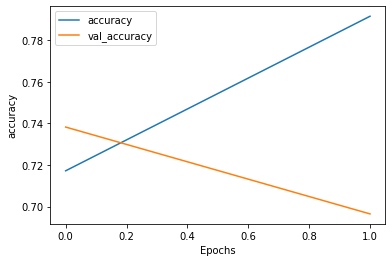

In [ ]:

plot_graphs(history, 'accuracy')

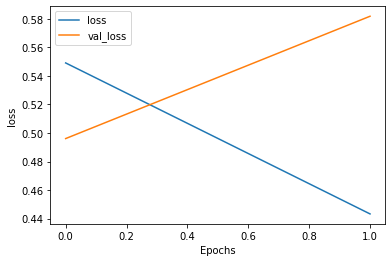

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
TEST_Q1_DATA_FILE = 'test_q1.npy'
TEST_Q2_DATA_FILE = 'test_q2.npy'
TEST_ID_DATA_FILE = 'test_id.npy'

test_q1_data = np.load(open(DATA_IN_PATH + TEST_Q1_DATA_FILE, 'rb'))
test_q2_data = np.load(open(DATA_IN_PATH + TEST_Q2_DATA_FILE, 'rb'))
test_id_data = np.load(open(DATA_IN_PATH + TEST_ID_DATA_FILE, 'rb'), allow_pickle=True)

In [ ]:
#베스트 모델 불러오기
SAVE_FILE_NM = 'weights.h5'
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [ ]:
#테스트 데이터 예측하기
predictions = model.predict((test_q1_data, test_q2_data), batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)
output = pd.DataFrame( data={"test_id":test_id_data, "is_duplicate": list(predictions)} )
output.to_csv(DATA_OUT_PATH + "cnn_predict.csv", index=False, quoting=3)